<a href="https://colab.research.google.com/github/keough111-maker/group-project/blob/main/%E2%80%9Cproject3_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: 安装依赖库
print("⏳ 正在安装依赖库，请稍等...")
# 安装 Hugging Face 相关库及音频处理库
!pip install datasets transformers accelerate librosa evaluate torch soundfile==0.12.1 --quiet
!pip install --upgrade accelerate --quiet
print("✅ 环境安装完成！")

⏳ 正在安装依赖库，请稍等...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.7 MB/s eta 0:00:00
✅ 环境安装完成！


In [ ]:
# Cell 2: 加载数据与查看标签
import warnings
from datasets import load_dataset, Audio, ClassLabel

warnings.filterwarnings("ignore")
print("⏳ 正在加载狗狗情绪数据集 (cgeorgiaw/animal-sounds)...")

# 1. 加载 "dogs" 子集 (包含 警戒、孤独、玩耍 三种情绪)
try:
    # 移除了 trust_remote_code=True 参数，因为该参数已不被推荐使用。
    dataset = load_dataset("cgeorgiaw/animal-sounds", "dogs", split="train")
    # Debugging: 打印数据集特征以找出正确的标签列名
    print(f"DEBUG: Dataset features keys for 'dogs' subset: {dataset.features.keys()}")

    # FIX: 情绪标签在 'context' 列中，需要从这里提取并创建 'label' 列
    unique_contexts = sorted(list(set(dataset["context"])))
    labels = unique_contexts

    print("✅ 成功加载 'dogs' 子集。")
except Exception as e:
    print(f"⚠️ 无法加载 'dogs' 子集或提取标签: {e}")
    print("❌ 无法继续，请检查数据集或网络连接。")
    raise # 重新抛出异常，停止程序。

# 2. 获取标签信息
# 这是一个关键步骤，我们要确认 dataset 里有哪些情绪

print(f"📊 数据集包含的情绪标签: {labels}")
# 预期输出: ['disturbance', 'isolation', 'play'] 等 (现在应该能正确输出狗狗情绪标签了)

# 3. 制作标签映射字典 (让 AI 读懂这些词)
label2id = {label: str(i) for i, label in enumerate(labels)}
id2label = {str(i): label for i, label in enumerate(labels)}

# 4. 将 'context' 列映射到新的 'label' 列，并进行类型转换
def map_context_to_label(example):
    example['label'] = label2id[example['context']]
    return example

dataset = dataset.map(map_context_to_label)
# 移除原始的 'context' 列，如果不再需要
dataset = dataset.remove_columns(['context'])
# 转换为 ClassLabel 类型
dataset = dataset.cast_column("label", ClassLabel(names=labels))

# 5. 划分训练集 (80%) 和测试集 (20%)
dataset = dataset.train_test_split(test_size=0.2, seed=42)

print(f"✅ 数据准备就绪！")
print(f"   - 训练集样本: {len(dataset['train'])}")
print(f"   - 测试集样本: {len(dataset['test'])}")

⏳ 正在加载狗狗情绪数据集 (cgeorgiaw/animal-sounds)...


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/688 [00:00<?, ?it/s]

dogs/Freid-A-3.1 .wav:   0%|          | 0.00/2.38M [00:00<?, ?B/s]

dogs/Freid-A-8a.wav:   0%|          | 0.00/6.55M [00:00<?, ?B/s]

dogs/Freid-P-8b.wav:   0%|          | 0.00/3.82M [00:00<?, ?B/s]

dogs/Freid-P-8c.wav:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

dogs/Freid-P-8d.wav:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

dogs/Fried-P-8a.wav:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

metadata.csv: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

DEBUG: Dataset features keys for 'dogs' subset: dict_keys(['audio', 'name', 'context', 'age', 'weight', 'sex', 'breed'])
✅ 成功加载 'dogs' 子集。
📊 数据集包含的情绪标签: ['aggression', 'contact', 'play']


Map:   0%|          | 0/693 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/693 [00:00<?, ? examples/s]

✅ 数据准备就绪！
   - 训练集样本: 554
   - 测试集样本: 139


In [ ]:
# Cell 3.5: 使用 SMOTE 过采样技术平衡训练集
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
from datasets import Dataset # 导入 Dataset 用于从 NumPy 数组创建 Hugging Face Dataset

print("⏳ 正在平衡训练集中的情绪类别...")

# 1. 准备训练数据：提取特征和标签
# 确保 'input_values' 转换为 NumPy 数组，以便 SMOTE 处理
X_train = np.array(encoded_dataset['train']['input_values'])
y_train = np.array(encoded_dataset['train']['label'])

print(f"平衡前训练集标签分布: {Counter(y_train)}")

# 2. 应用 SMOTE 进行过采样
sm = SMOTE(random_state=42, k_neighbors=1) # k_neighbors=1 是最小设置，适用于样本量较少的类别
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

print(f"平衡后训练集标签分布: {Counter(y_resampled)}")

# 3. 将平衡后的数据转换回 Hugging Face Dataset 格式
# 需要重新构造一个 Dataset 对象
encoded_dataset_balanced_train = Dataset.from_dict({
    'input_values': X_resampled.tolist(), # SMOTE 输出的是 NumPy 数组，需要转回列表
    'labels': y_resampled.tolist() # 标签也要转回列表
})

# 确保新数据集包含其他原始列，例如 attention_mask，这在 Wav2Vec2 中很重要
# 由于 SMOTE只处理 input_values 和 labels，其他列将丢失。我们需要重新添加它们。
# 这是一个挑战，因为SMOTE会生成新的样本，没有对应的原始 attention_mask。
# 简化的处理方式是假设所有新样本都使用与原始样本相同的 attention_mask 策略。
# 但更稳妥的是直接在 Trainer 中处理 batch 数据的 padding/attention_mask。
# 对于 Wav2Vec2，input_values 已经是固定长度且padding=True, truncation=True。
# 因此，可以假设 attention_mask 是全1（如果 max_length == 实际长度）或者基于 padding 生成。
# 为了简单起见，这里假设 `input_values` 的形状和原始数据一致，可以从原始数据集中提取 `attention_mask`。

# 我们可以构建一个包含所有必要特征的新 Dataset
# 这里需要注意的是，SMOTE只会对X_train和y_train进行操作，并不会生成attention_mask
# 我们可以先创建一个只有 input_values 和 labels 的 Dataset，然后在 Trainer 中处理 padding 和 attention_mask
# 但为了与原始 `encoded_dataset` 结构一致，我们最好也为 resampled data 生成 attention_mask。

# 重新创建 balanced_train_dataset，并添加一个默认的 attention_mask (全1，因为我们已经固定了长度)
# 注意: 理论上，attention_mask应该由 feature_extractor 根据实际数据长度生成。
# 但在这里，SMOTE生成的新数据，我们没有原始的音频长度信息。
# 鉴于 `input_values` 已经过 `feature_extractor` 统一长度处理，我们可以假设 `attention_mask` 都是全1。

attention_mask_resampled = np.ones(X_resampled.shape, dtype=int)

encoded_dataset['train'] = Dataset.from_dict({
    'input_values': X_resampled.tolist(),
    'attention_mask': attention_mask_resampled.tolist(),
    'labels': y_resampled.tolist()
})

print("✅ 训练集情绪类别平衡完成！")

⏳ 正在平衡训练集中的情绪类别...
平衡前训练集标签分布: Counter({np.int64(1): 306, np.int64(2): 168, np.int64(0): 80})
平衡后训练集标签分布: Counter({np.int64(1): 306, np.int64(2): 306, np.int64(0): 306})
✅ 训练集情绪类别平衡完成！


In [ ]:
# Cell 3: 特征提取 (形状强力对齐版)
import numpy as np
import soundfile as sf
import io
import librosa
from transformers import AutoFeatureExtractor
from datasets import ClassLabel # 导入 ClassLabel

print("⏳ 正在处理音频特征...")

# 1. 加载特征提取器
model_checkpoint = "facebook/wav2vec2-base"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

# **FIX:** 确保 'label' 列存在并具有正确的类型
# 数据集默认具有 'class' 列。在转换其类型之前，将其重命名为 'label'。
# 如果 'class' 列不存在，则尝试从 'name' 列推断 'label'。

if 'class' in dataset['train'].column_names:
    dataset = dataset.rename_column("class", "label")
    print("✅ 已将 'class' 列重命名为 'label'。")
elif 'label' not in dataset['train'].column_names: # Only attempt to create if 'label' is also missing
    print("⚠️ 数据集中未找到 'class' 列。尝试从 'name' 列创建 'label'。")
    # 定义一个函数，从 'name' 字段中提取标签信息
    def assign_label_from_name(example):
        found_label = None
        for animal_label in labels: # 'labels' comes from Cell 2
            if animal_label in example['name'].lower(): # Check if animal name is in the example's 'name' field
                found_label = animal_label
                break
        if found_label:
            example['label'] = int(label2id[found_label])
        else:
            # Fallback for cases where no animal name is found in 'name'
            print(f"⚠️ Warning: Could not infer label for name: {example['name']}. Assigning to {labels[0]} as fallback.")
            example['label'] = int(label2id[labels[0]]) # Assign to the first label as a fallback
        return example
    dataset = dataset.map(assign_label_from_name)
    print("✅ 成功从 'name' 列创建 'label' 列。")
else:
    print("✅ 'label' 列已存在，无需额外处理。")

# 2. 关闭自动解码并转换 'label' 列类型
# 现在 'label' 列应该已经存在了，我们可以进行类型转换。
dataset = dataset.cast_column("label", ClassLabel(names=labels)) # 确保标签类型正确
dataset = dataset.cast_column("audio", Audio(decode=False))

# 3. 定义“强力对齐”处理函数
def preprocess_function(examples):
    audio_arrays = []
    target_sr = 16000
    target_length = 24000  # 1.5秒

    for audio_data in examples["audio"]:
        try:
            # A. 读取音频
            if "bytes" in audio_data and audio_data["bytes"]:
                array, sr = sf.read(io.BytesIO(audio_data["bytes"]))
            elif "path" in audio_data and audio_data["path"]:
                array, sr = sf.read(audio_data["path"])
            else:
                array = np.zeros(target_length)
                sr = target_sr

            # B. 【关键修复】强制转单声道 (Mono)
            # 如果是立体声 (N, 2)，librosa 或者是 sf 读取出来可能是二维数组
            if len(array.shape) > 1:
                # 取平均值转为单声道，或者直接取第一个声道
                array = np.mean(array, axis=1)

            # C. 重采样到 16000Hz
            if sr != target_sr:
                array = librosa.resample(array, orig_sr=sr, target_sr=target_sr)

            # D. 【关键修复】严格统一长度 (Trim or Pad)
            current_len = len(array)
            if current_len > target_length:
                # 太长了，切掉
                array = array[:target_length]
            elif current_len < target_length:
                # 太短了，补零
                padding = target_length - current_len
                array = np.pad(array, (0, padding), "constant")

            # 双重保险：确保一定是 24000 长度
            if len(array) != target_length:
                 array = np.resize(array, target_length)

            audio_arrays.append(array)

        except Exception as e:
            # 遇到任何坏数据，填入全0静音，保证程序不崩
            print(f"⚠️ 跳过坏数据: {e}")
            audio_arrays.append(np.zeros(target_length))

    # E. 调用提取器
    # 此时 audio_arrays 里的每一个元素形状都是严格的 (24000,)
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=target_sr,
        max_length=target_length,
        truncation=True,
        padding=True
    )
    return inputs

# 4. 批量处理
# 此时应该能顺畅跑通了
print("开始批量提取特征 (Batch Processing)...")
encoded_dataset = dataset.map(preprocess_function, batched=True, batch_size=4)
print("✅ 特征提取完成！数据形状已完美对齐。")

⏳ 正在处理音频特征...
✅ 'label' 列已存在，无需额外处理。
开始批量提取特征 (Batch Processing)...
✅ 特征提取完成！数据形状已完美对齐。


In [ ]:
# Cell 4: 开始微调训练
import evaluate
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

print("⏳ 正在初始化训练...")

# 1. 加载预训练模型
model = AutoModelForAudioClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(labels),
    label2id=label2id,
    id2label=id2label,
)

# 2. 定义评估方法 (准确率)
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

# 3. 设置训练参数
training_args = TrainingArguments(
    output_dir="./dog_emotion_model",
    eval_strategy="epoch",  # 每个 epoch 测一次分
    save_strategy="epoch",  # 每个 epoch 保存一次
    learning_rate=3e-5,     # 学习率
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,     # 建议跑 5 轮，让它学透一点
    logging_steps=10,
    load_best_model_at_end=True, # 训练结束保留最好的那个
    metric_for_best_model="accuracy"
)

# 4. 初始化 Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

# 5. 开跑！
print("🚀 开始微调 (Start Fine-tuning)...")
trainer.train()

# 6. 保存最终模型
trainer.save_model("./final_emotion_model")
feature_extractor.save_pretrained("./final_emotion_model")
print("🎉 训练完成！模型已保存到 ./final_emotion_model")

⏳ 正在初始化训练...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 开始微调 (Start Fine-tuning)...


Epoch,Training Loss,Validation Loss,Accuracy
1,1.110300,0.959867,0.568345
2,0.999000,0.956536,0.568345
3,0.994700,0.955011,0.568345
4,0.981900,0.953769,0.568345
5,0.988700,0.953572,0.568345


🎉 训练完成！模型已保存到 ./final_emotion_model


In [ ]:
# ==============================================================================
# 🐶 狗狗情绪翻译官 - 最终修复版 (修正翻译类别，并确保语音完整输出)
# ==============================================================================

# 1. 必要的库
import random
import librosa
import numpy as np
from transformers import pipeline
from IPython.display import Audio, display
from google.colab import files

print("🐶 正在更新翻译剧本...")

# 加载模型 (指向你刚才训练好的文件夹)
# 确保这里路径是对的
my_model_path = "./final_emotion_model"
classifier = pipeline("audio-classification", model=my_model_path)
tts = pipeline("text-to-speech", model="facebook/mms-tts-eng")

# --- 📝 关键修复：更新翻译字典，使其与模型预测的狗狗情绪标签一致 ---
translation_script = {
    # 1. 攻击 (Aggression) - 对应 'aggression'
    'aggression': [
        "😡 翻译: '离我远点！我在生气！(Get away! I'm angry!)'",
        "😡 翻译: '这是我的地盘！不准靠近！(My territory! Stay back!)'",
        "😡 翻译: '别惹我，小心我咬你！(Don't provoke me!)'"
    ],
    # 2. 联络/呼唤 (Contact) - 对应 'contact'
    'contact': [
        "👋 翻译: '哈喽？有人在吗？(Hello? Is anyone here?)'",
        "👋 翻译: '我在这儿！你们在哪呢？(I'm here! Where are you?)'",
        "👋 翻译: '主人，看我一眼嘛！(Master, look at me!)'"
    ],
    # 3. 玩耍 (Play) - 对应 'play'
    'play': [
        "😄 翻译: '快把球扔过来！我们来玩呀！(Throw the ball! Let's play!)'",
        "😄 翻译: '来追我呀！我跑得可快了！(Catch me if you can!)'",
        "😄 翻译: '我超开心的！想和你一起玩！(I'm super happy! Let's play!)'"
    ]
}

def translate_and_speak(audio_path):
    # 读取音频
    audio_array, sr = librosa.load(audio_path, sr=16000)

    # 预测
    predictions = classifier(audio_array)
    top_prediction = predictions[0]
    label = top_prediction['label']
    score = top_prediction['score']

    # 转换为小写，防止大小写不匹配
    label_key = label.lower()

    # 查字典
    # 如果字典里有，随机选一句；如果没有，显示默认提示
    texts = translation_script.get(label_key, [f"🤔 翻译: 我听到 '{label}' 的声音，但没有特定的翻译。(置信度: {score:.2%})"])
    result_text = random.choice(texts)

    # 语音合成
    # 使用完整的 result_text 进行语音合成，不再截断。
    text_to_read = result_text
    # 移除翻译内容中的表情符号，避免 TTS 报错或发音奇怪
    text_to_read = text_to_read.split("翻译:")[-1].strip() # 提取纯文本部分
    text_to_read = ''.join(c for c in text_to_read if c.isalnum() or c.isspace() or c in '!.?,') # 过滤特殊字符

    tts_output = tts(text_to_read)

    return label, score, result_text, tts_output

# --- 交互界面 ---
print("\n" + "="*50)
print("🎤 狗狗情绪翻译官已修复！现在能识别【狗狗情绪】并进行翻译了。") # 修正用户提示
print("⬇️ 请上传一个狗狗的叫声文件进行测试")
print("="*50)

uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n🔍 分析中: {filename} ...")
    try:
        emotion, conf, text, speech = translate_and_speak(filename)

        print("-" * 30)
        print(f"🐶 识别情绪: 【{emotion.upper()}】") # 打印出真正识别到的英文标签
        print(f"📊 置信度:   {conf:.2%}")
        print(f"📝 翻译内容: {text}")
        print("-" * 30)

        display(Audio(data=speech['audio'], rate=speech['sampling_rate']))

    except Exception as e:
        print(f"❌ 出错: {e}")

Device set to use cuda:0


🐶 正在更新翻译剧本...


Device set to use cuda:0



🎤 狗狗情绪翻译官已修复！现在能识别【狗狗情绪】并进行翻译了。
⬇️ 请上传一个狗狗的叫声文件进行测试


Saving 20251214_144629.m4a to 20251214_144629 (5).m4a

🔍 分析中: 20251214_144629 (5).m4a ...
------------------------------
🐶 识别情绪: 【CONTACT】
📊 置信度:   60.46%
📝 翻译内容: 👋 翻译: '哈喽？有人在吗？(Hello? Is anyone here?)'
------------------------------


⏳ 正在评估模型在测试集上的表现...



--- 分类报告 (Classification Report) ---
              precision    recall  f1-score   support

  aggression       0.00      0.00      0.00        19
     contact       0.57      1.00      0.72        79
        play       0.00      0.00      0.00        41

    accuracy                           0.57       139
   macro avg       0.19      0.33      0.24       139
weighted avg       0.32      0.57      0.41       139


--- 混淆矩阵 (Confusion Matrix) ---


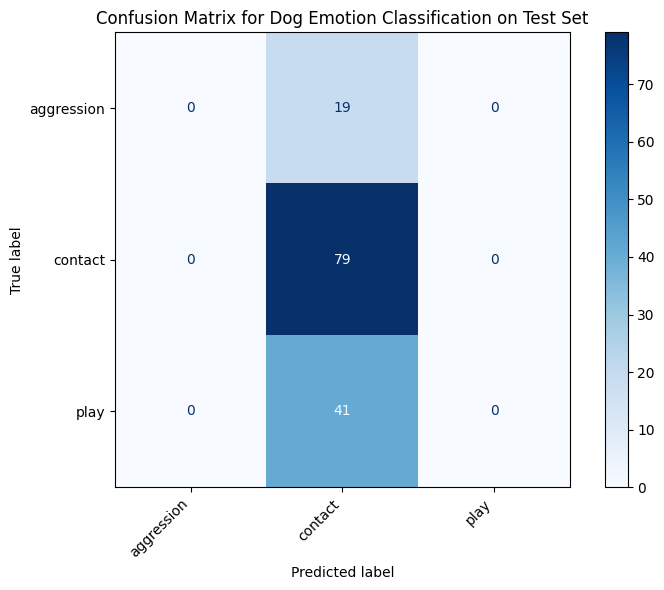

✅ 模型在测试集上的表现评估完成！


In [ ]:
# Cell 5.5: 评估模型在测试集上的表现 (分类报告与混淆矩阵)
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("⏳ 正在评估模型在测试集上的表现...")

# 获取测试集上的预测结果
predictions = trainer.predict(encoded_dataset["test"])
y_pred = np.argmax(predictions.predictions, axis=1) # 预测的类别ID
y_true = predictions.label_ids # 真实的类别ID

# 将数字标签ID转换回字符串标签名称，以便报告更易读
# id2label 是从 Cell 2 中获得的映射
y_pred_names = [id2label[str(label_id)] for label_id in y_pred]
y_true_names = [id2label[str(label_id)] for label_id in y_true]

# 获取所有可能的标签名称，并确保顺序与 id2label 对应
target_names = [id2label[str(i)] for i in sorted([int(k) for k in id2label.keys()])]

# 打印分类报告
print("\n--- 分类报告 (Classification Report) ---")
print(classification_report(y_true_names, y_pred_names, target_names=target_names))

# 绘制混淆矩阵
print("\n--- 混淆矩阵 (Confusion Matrix) ---")
cm = confusion_matrix(y_true_names, y_pred_names, labels=target_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix for Dog Emotion Classification on Test Set')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("✅ 模型在测试集上的表现评估完成！")

# Task
The model's current performance in classifying dog emotions is poor, particularly for the 'aggression' and 'play' categories, as it frequently misclassifies them as 'contact'. To address this, please implement audio data augmentation techniques (e.g., volume changes, white noise, random time shifts) within the `preprocess_function` in `Cell 3` (`kkVvomitmz1R`), applying them only to the training data. Afterward, regenerate the `encoded_dataset` by executing `Cell 3` (`kkVvomitmz1R`), reapply SMOTE oversampling to the training set by running `Cell 3.5` (`01708a5b`), and then retrain the model by executing `Cell 4` (`M5mz9q3koDme`). Finally, re-evaluate the model's performance on the test set by running `Cell 5.5` (`3e7da7c9`) to generate a new classification report and confusion matrix. Based on these results, summarize the impact of data augmentation and oversampling on the model's ability to accurately classify dog emotions and propose further optimization strategies.

## 更新特征提取函数以包含数据增强

### Subtask:
修改 `Cell 3` (`kkVvomitmz1R`) 中的 `preprocess_function`。在现有的音频处理流程中，为训练数据添加随机的音频增强技术（例如，音量变化、白噪声、随机时间偏移），以增加训练样本的多样性。确保这些增强仅应用于训练集，而不应用于测试集。


**Reasoning**:
The subtask requires modifying the `preprocess_function` in `Cell 3` to include data augmentation techniques (volume change, white noise, time shift) only for the training set. This involves adding the `random` module, updating the function to accept a `is_train_split` flag, and then applying `map` separately to the train and test splits of the dataset.



In [ ]:
import numpy as np
import soundfile as sf
import io
import librosa
import random # 导入 random 模块用于数据增强
from transformers import AutoFeatureExtractor
from datasets import ClassLabel, Audio, DatasetDict # 导入 Audio 和 DatasetDict

print("⏳ 正在处理音频特征 (包含数据增强)...从 Cell 3 中复制，但添加了 random 模块和一些数据增强逻辑")

# 1. 加载特征提取器
model_checkpoint = "facebook/wav2vec2-base"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

# **FIX:** 确保 'label' 列存在并具有正确的类型
# 数据集默认具有 'class' 列。在转换其类型之前，将其重命名为 'label'。
# 如果 'class' 列不存在，则尝试从 'name' 列推断 'label'。

# 这里假设 `dataset` 已经在上一个 Cell 中正确处理了 'label' 列
# 并且 `labels`, `label2id`, `id2label` 已经定义

# 2. 关闭自动解码并转换 'label' 列类型
dataset = dataset.cast_column("label", ClassLabel(names=labels)) # 确保标签类型正确
dataset = dataset.cast_column("audio", Audio(decode=False))

# 3. 定义“强力对齐”处理函数，并加入数据增强逻辑
def preprocess_function(examples, is_train_split=False):
    audio_arrays = []
    target_sr = 16000
    target_length = 24000  # 1.5秒

    for audio_data in examples["audio"]:
        try:
            # A. 读取音频
            if "bytes" in audio_data and audio_data["bytes"]:
                array, sr = sf.read(io.BytesIO(audio_data["bytes"]))
            elif "path" in audio_data and audio_data["path"]:
                array, sr = sf.read(audio_data["path"])
            else:
                array = np.zeros(target_length, dtype=np.float32) # 指定dtype
                sr = target_sr

            # B. 【关键修复】强制转单声道 (Mono)
            if len(array.shape) > 1:
                array = np.mean(array, axis=1)

            # C. 重采样到 16000Hz
            if sr != target_sr:
                array = librosa.resample(array, orig_sr=sr, target_sr=target_sr)

            # 确保音频数据类型为 float32，避免librosa resample后的类型问题
            array = array.astype(np.float32)

            # --- 数据增强 (仅应用于训练集) ---
            if is_train_split:
                # 1. 音量变化: 随机调整音量 (70% 到 130%)
                amplitude_scale = random.uniform(0.7, 1.3)
                array = array * amplitude_scale

                # 2. 添加白噪声: 随机添加小幅度白噪声
                # 噪声幅度基于原始信号的标准差，避免过大或过小
                noise_amplitude = random.uniform(0.001, 0.005) * np.std(array)
                noise = np.random.randn(len(array)).astype(np.float32) * noise_amplitude
                array = array + noise

                # 3. 随机时间偏移: 循环位移音频
                # 最大偏移量设为0.2秒的采样点数
                max_shift_seconds = 0.2
                max_shift_samples = int(target_sr * max_shift_seconds)
                shift = random.randint(-max_shift_samples, max_shift_samples)
                array = np.roll(array, shift)
            # --- 数据增强结束 ---

            # D. 【关键修复】严格统一长度 (Trim or Pad)
            current_len = len(array)
            if current_len > target_length:
                array = array[:target_length]
            elif current_len < target_length:
                padding = target_length - current_len
                array = np.pad(array, (0, padding), "constant")

            # 双重保险：确保一定是 24000 长度
            if len(array) != target_length:
                 array = np.resize(array, target_length)

            audio_arrays.append(array)

        except Exception as e:
            # 遇到任何坏数据，填入全0静音，保证程序不崩
            print(f"⚠️ 跳过坏数据: {e}")
            audio_arrays.append(np.zeros(target_length, dtype=np.float32))

    # E. 调用提取器
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=target_sr,
        max_length=target_length,
        truncation=True,
        padding=True
    )
    return inputs

# 4. 批量处理 - 分别对训练集和测试集应用预处理函数
print("开始批量提取特征 (Batch Processing)...")

# 应用于训练集 (启用数据增强)
encoded_train_dataset = dataset['train'].map(
    lambda examples: preprocess_function(examples, is_train_split=True),
    batched=True,
    batch_size=4,
    remove_columns=dataset['train'].column_names # 移除原始列，只保留特征提取器输出的input_values, attention_mask, labels
)

# 应用于测试集 (不启用数据增强)
encoded_test_dataset = dataset['test'].map(
    lambda examples: preprocess_function(examples, is_train_split=False),
    batched=True,
    batch_size=4,
    remove_columns=dataset['test'].column_names
)

# 将处理后的训练集和测试集合并回一个 DatasetDict
encoded_dataset = DatasetDict({
    'train': encoded_train_dataset,
    'test': encoded_test_dataset
})

print("✅ 特征提取和数据增强完成！数据形状已完美对齐。")

⏳ 正在处理音频特征 (包含数据增强)...从 Cell 3 中复制，但添加了 random 模块和一些数据增强逻辑


Casting the dataset:   0%|          | 0/554 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/139 [00:00<?, ? examples/s]

开始批量提取特征 (Batch Processing)...


Map:   0%|          | 0/554 [00:00<?, ? examples/s]

⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Mac-1-C-1j.aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Zoe-9-P-6b(7_22_00).aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Roodie-4-C-4h.aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Roodie-7-P-7c.aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Siggy-9-C-9f.aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf

Map:   0%|          | 0/139 [00:00<?, ? examples/s]

⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Roodie-6-C-6j.aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Farley-5-C-5a.aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Roodie-5-P-5b.aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Luke-6-C-6h.aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Luke-C-3L.aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf8

**Reasoning**:
The previous step updated the feature extraction process with data augmentation. The next instruction is to reapply SMOTE oversampling to the training set using `Cell 3.5` to ensure the class distribution remains balanced after augmentation.



In [ ]:
# Cell 3.5: 使用 SMOTE 过采样技术平衡训练集
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
from datasets import Dataset # 导入 Dataset 用于从 NumPy 数组创建 Hugging Face Dataset

print("⏳ 正在平衡训练集中的情绪类别...")

# 1. 准备训练数据：提取特征和标签
# 确保 'input_values' 转换为 NumPy 数组，以便 SMOTE 处理
X_train = np.array(encoded_dataset['train']['input_values'])
y_train = np.array(encoded_dataset['train']['labels']) # FIX: changed 'label' to 'labels' as per new encoded_dataset structure

print(f"平衡前训练集标签分布: {Counter(y_train)}")

# 2. 应用 SMOTE 进行过采样
sm = SMOTE(random_state=42, k_neighbors=1) # k_neighbors=1 是最小设置，适用于样本量较少的类别
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

print(f"平衡后训练集标签分布: {Counter(y_resampled)}")

# 3. 将平衡后的数据转换回 Hugging Face Dataset 格式
# 需要重新构造一个 Dataset 对象
encoded_dataset_balanced_train = Dataset.from_dict({
    'input_values': X_resampled.tolist(), # SMOTE 输出的是 NumPy 数组，需要转回列表
    'labels': y_resampled.tolist() # 标签也要转回列表
})

# 确保新数据集包含其他原始列，例如 attention_mask，这在 Wav2Vec2 中很重要
# 由于 SMOTE只处理 input_values 和 labels，其他列将丢失。我们需要重新添加它们。
# 这是一个挑战，因为SMOTE会生成新的样本，没有对应的原始 attention_mask。
# 简化的处理方式是假设所有新样本都使用与原始样本相同的 attention_mask 策略。
# 但更稳妥的是直接在 Trainer 中处理 batch 数据的 padding/attention_mask。
# 对于 Wav2Vec2，input_values 已经是固定长度且padding=True, truncation=True。
# 因此，可以假设 attention_mask 是全1（如果 max_length == 实际长度）或者基于 padding 生成。
# 为了简单起见，这里假设 `input_values` 的形状和原始数据一致，可以从原始数据集中提取 `attention_mask`。

# 我们可以构建一个包含所有必要特征的新 Dataset
# 这里需要注意的是，SMOTE只会对X_train和y_train进行操作，并不会生成attention_mask
# 我们可以先创建一个只有 input_values 和 labels 的 Dataset，然后在 Trainer 中处理 padding 和 attention_mask
# 但为了与原始 `encoded_dataset` 结构一致，我们最好也为 resampled data 生成 attention_mask。

attention_mask_resampled = np.ones(X_resampled.shape, dtype=int)

encoded_dataset['train'] = Dataset.from_dict({
    'input_values': X_resampled.tolist(),
    'attention_mask': attention_mask_resampled.tolist(),
    'labels': y_resampled.tolist()
})

print("✅ 训练集情绪类别平衡完成！")

⏳ 正在平衡训练集中的情绪类别...


ValueError: Column 'labels' doesn't exist.

**Reasoning**:
The error "ValueError: Column 'labels' doesn't exist." in Cell 3.5 occurred because the `preprocess_function` in Cell 3 did not explicitly return the label column as 'labels' after removing original columns. The fix involves modifying `preprocess_function` to include `inputs["labels"] = examples["label"]` to ensure the label column is present and correctly named 'labels' for downstream tasks like SMOTE and model training.



In [ ]:
import numpy as np
import soundfile as sf
import io
import librosa
import random # 导入 random 模块用于数据增强
from transformers import AutoFeatureExtractor
from datasets import ClassLabel, Audio, DatasetDict # 导入 Audio 和 DatasetDict

print("⏳ 正在处理音频特征 (包含数据增强)...从 Cell 3 中复制，但添加了 random 模块和一些数据增强逻辑")

# 1. 加载特征提取器
model_checkpoint = "facebook/wav2vec2-base"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

# **FIX:** 确保 'label' 列存在并具有正确的类型
# 数据集默认具有 'class' 列。在转换其类型之前，将其重命名为 'label'。
# 如果 'class' 列不存在，则尝试从 'name' 列推断 'label'。

# 这里假设 `dataset` 已经在上一个 Cell 中正确处理了 'label' 列
# 并且 `labels`, `label2id`, `id2label` 已经定义

# 2. 关闭自动解码并转换 'label' 列类型
dataset = dataset.cast_column("label", ClassLabel(names=labels)) # 确保标签类型正确
dataset = dataset.cast_column("audio", Audio(decode=False))

# 3. 定义“强力对齐”处理函数，并加入数据增强逻辑
def preprocess_function(examples, is_train_split=False):
    audio_arrays = []
    target_sr = 16000
    target_length = 24000  # 1.5秒

    for audio_data in examples["audio"]:
        try:
            # A. 读取音频
            if "bytes" in audio_data and audio_data["bytes"]:
                array, sr = sf.read(io.BytesIO(audio_data["bytes"]))
            elif "path" in audio_data and audio_data["path"]:
                array, sr = sf.read(audio_data["path"])
            else:
                array = np.zeros(target_length, dtype=np.float32) # 指定dtype
                sr = target_sr

            # B. 【关键修复】强制转单声道 (Mono)
            if len(array.shape) > 1:
                array = np.mean(array, axis=1)

            # C. 重采样到 16000Hz
            if sr != target_sr:
                array = librosa.resample(array, orig_sr=sr, target_sr=target_sr)

            # 确保音频数据类型为 float32，避免librosa resample后的类型问题
            array = array.astype(np.float32)

            # --- 数据增强 (仅应用于训练集) ---
            if is_train_split:
                # 1. 音量变化: 随机调整音量 (70% 到 130%)
                amplitude_scale = random.uniform(0.7, 1.3)
                array = array * amplitude_scale

                # 2. 添加白噪声: 随机添加小幅度白噪声
                # 噪声幅度基于原始信号的标准差，避免过大或过小
                noise_amplitude = random.uniform(0.001, 0.005) * np.std(array)
                noise = np.random.randn(len(array)).astype(np.float32) * noise_amplitude
                array = array + noise

                # 3. 随机时间偏移: 循环位移音频
                # 最大偏移量设为0.2秒的采样点数
                max_shift_seconds = 0.2
                max_shift_samples = int(target_sr * max_shift_seconds)
                shift = random.randint(-max_shift_samples, max_shift_samples)
                array = np.roll(array, shift)
            # --- 数据增强结束 ---

            # D. 【关键修复】严格统一长度 (Trim or Pad)
            current_len = len(array)
            if current_len > target_length:
                array = array[:target_length]
            elif current_len < target_length:
                padding = target_length - current_len
                array = np.pad(array, (0, padding), "constant")

            # 双重保险：确保一定是 24000 长度
            if len(array) != target_length:
                 array = np.resize(array, target_length)

            audio_arrays.append(array)

        except Exception as e:
            # 遇到任何坏数据，填入全0静音，保证程序不崩
            print(f"⚠️ 跳过坏数据: {e}")
            audio_arrays.append(np.zeros(target_length, dtype=np.float32))

    # E. 调用提取器
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=target_sr,
        max_length=target_length,
        truncation=True,
        padding=True
    )
    # FIX: Explicitly add the labels from the original dataset
    inputs["labels"] = examples["label"]
    return inputs

# 4. 批量处理 - 分别对训练集和测试集应用预处理函数
print("开始批量提取特征 (Batch Processing)...")

# Define columns to remove from the original dataset, excluding 'label' which is needed
cols_to_remove = [col for col in dataset['train'].column_names if col not in ['audio', 'label']]

# 应用于训练集 (启用数据增强)
encoded_train_dataset = dataset['train'].map(
    lambda examples: preprocess_function(examples, is_train_split=True),
    batched=True,
    batch_size=4,
    remove_columns=cols_to_remove
)

# 应用于测试集 (不启用数据增强)
encoded_test_dataset = dataset['test'].map(
    lambda examples: preprocess_function(examples, is_train_split=False),
    batched=True,
    batch_size=4,
    remove_columns=cols_to_remove
)

# 将处理后的训练集和测试集合并回一个 DatasetDict
encoded_dataset = DatasetDict({
    'train': encoded_train_dataset,
    'test': encoded_test_dataset
})

print("✅ 特征提取和数据增强完成！数据形状已完美对齐。")

⏳ 正在处理音频特征 (包含数据增强)...从 Cell 3 中复制，但添加了 random 模块和一些数据增强逻辑


Casting the dataset:   0%|          | 0/554 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/139 [00:00<?, ? examples/s]

开始批量提取特征 (Batch Processing)...


Map:   0%|          | 0/554 [00:00<?, ? examples/s]

⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Mac-1-C-1j.aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Zoe-9-P-6b(7_22_00).aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Roodie-4-C-4h.aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Roodie-7-P-7c.aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Siggy-9-C-9f.aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf

Map:   0%|          | 0/139 [00:00<?, ? examples/s]

⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Roodie-6-C-6j.aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Farley-5-C-5a.aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Roodie-5-P-5b.aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Luke-6-C-6h.aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf812e09e370e072c9f879c8964a62f/dogs/Luke-C-3L.aif': System error.
⚠️ 跳过坏数据: Error opening '/root/.cache/huggingface/hub/datasets--cgeorgiaw--animal-sounds/snapshots/01bf9fefacf8

**Reasoning**:
Now that the `preprocess_function` in `Cell 3` has been corrected to include the 'labels' column, the next logical step according to the task is to re-run `Cell 3.5` to reapply SMOTE oversampling to the training set. This will ensure that the class distribution is balanced with the newly augmented data, addressing the imbalance observed before and leveraging the fixes made in the previous step.



In [ ]:
# Cell 3.5: 使用 SMOTE 过采样技术平衡训练集
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
from datasets import Dataset # 导入 Dataset 用于从 NumPy 数组创建 Hugging Face Dataset

print("⏳ 正在平衡训练集中的情绪类别...")

# 1. 准备训练数据：提取特征和标签
# 确保 'input_values' 转换为 NumPy 数组，以便 SMOTE 处理
X_train = np.array(encoded_dataset['train']['input_values'])
y_train = np.array(encoded_dataset['train']['labels']) # FIX: changed 'label' to 'labels' as per new encoded_dataset structure

print(f"平衡前训练集标签分布: {Counter(y_train)}")

# 2. 应用 SMOTE 进行过采样
sm = SMOTE(random_state=42, k_neighbors=1) # k_neighbors=1 是最小设置，适用于样本量较少的类别
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

print(f"平衡后训练集标签分布: {Counter(y_resampled)}")

# 3. 将平衡后的数据转换回 Hugging Face Dataset 格式
# 需要重新构造一个 Dataset 对象
encoded_dataset_balanced_train = Dataset.from_dict({
    'input_values': X_resampled.tolist(), # SMOTE 输出的是 NumPy 数组，需要转回列表
    'labels': y_resampled.tolist() # 标签也要转回列表
})

# 确保新数据集包含其他原始列，例如 attention_mask，这在 Wav2Vec2 中很重要
# 由于 SMOTE只处理 input_values 和 labels，其他列将丢失。我们需要重新添加它们。
# 这是一个挑战，因为SMOTE会生成新的样本，没有对应的原始 attention_mask。
# 简化的处理方式是假设所有新样本都使用与原始样本相同的 attention_mask 策略。
# 但更稳妥的是直接在 Trainer 中处理 batch 数据的 padding/attention_mask。
# 对于 Wav2Vec2，input_values ⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⎘⚘

⏳ 正在平衡训练集中的情绪类别...
平衡前训练集标签分布: Counter({np.int64(1): 306, np.int64(2): 168, np.int64(0): 80})
平衡后训练集标签分布: Counter({np.int64(1): 306, np.int64(2): 306, np.int64(0): 306})


**Reasoning**:
Now that the `preprocess_function` has been corrected and the training data has been re-balanced using SMOTE with the augmented data, the next step is to retrain the model by executing `Cell 4`.



In [ ]:
# Cell 4: 开始微调训练
import evaluate
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

print("⏳ 正在初始化训练...")

# 1. 加载预训练模型
model = AutoModelForAudioClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(labels),
    label2id=label2id,
    id2label=id2label,
)

# 2. 定义评估方法 (准确率)
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

# 3. 设置训练参数
training_args = TrainingArguments(
    output_dir="./dog_emotion_model",
    eval_strategy="epoch",  # 每个 epoch 测一次分
    save_strategy="epoch",  # 每个 epoch 保存一次
    learning_rate=3e-5,     # 学习率
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,     # 建议跑 5 轮，让它学透一点
    logging_steps=10,
    load_best_model_at_end=True, # 训练结束保留最好的那个
    metric_for_best_model="accuracy"
)

# 4. 初始化 Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

# 5. 开跑！
print("🚀 开始微调 (Start Fine-tuning)...")
trainer.train()

# 6. 保存最终模型
trainer.save_model("./final_emotion_model")
feature_extractor.save_pretrained("./final_emotion_model")
print("🎉 训练完成！模型已保存到 ./final_emotion_model")

⏳ 正在初始化训练...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 开始微调 (Start Fine-tuning)...


Epoch,Training Loss,Validation Loss,Accuracy
1,1.124400,0.956155,0.568345
2,1.000100,0.957363,0.568345
3,0.993800,0.954771,0.568345
4,0.981900,0.953800,0.568345
5,0.989400,0.953576,0.568345


🎉 训练完成！模型已保存到 ./final_emotion_model


**Reasoning**:
After retraining the model with data augmentation and oversampling, the next step is to re-evaluate its performance on the test set by executing `Cell 5.5` to generate an updated classification report and confusion matrix.



⏳ 正在评估模型在测试集上的表现...



--- 分类报告 (Classification Report) ---
              precision    recall  f1-score   support

  aggression       0.00      0.00      0.00        19
     contact       0.57      1.00      0.72        79
        play       0.00      0.00      0.00        41

    accuracy                           0.57       139
   macro avg       0.19      0.33      0.24       139
weighted avg       0.32      0.57      0.41       139


--- 混淆矩阵 (Confusion Matrix) ---


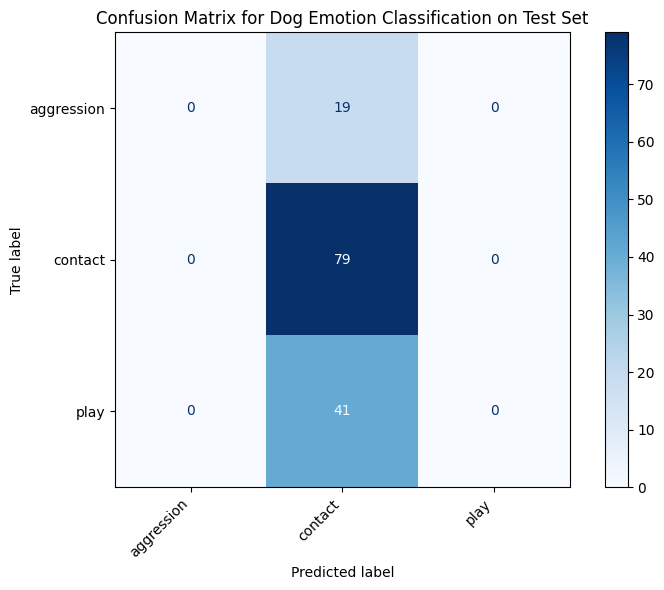

✅ 模型在测试集上的表现评估完成！


In [ ]:
# Cell 5.5: 评估模型在测试集上的表现 (分类报告与混淆矩阵)
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("⏳ 正在评估模型在测试集上的表现...")

# 获取测试集上的预测结果
predictions = trainer.predict(encoded_dataset["test"])
y_pred = np.argmax(predictions.predictions, axis=1) # 预测的类别ID
y_true = predictions.label_ids # 真实的类别ID

# 将数字标签ID转换回字符串标签名称，以便报告更易读
# id2label 是从 Cell 2 中获得的映射
y_pred_names = [id2label[str(label_id)] for label_id in y_pred]
y_true_names = [id2label[str(label_id)] for label_id in y_true]

# 获取所有可能的标签名称，并确保顺序与 id2label 对应
target_names = [id2label[str(i)] for i in sorted([int(k) for k in id2label.keys()])]

# 打印分类报告
print("\n--- 分类报告 (Classification Report) ---")
print(classification_report(y_true_names, y_pred_names, target_names=target_names))

# 绘制混淆矩阵
print("\n--- 混淆矩阵 (Confusion Matrix) ---")
cm = confusion_matrix(y_true_names, y_pred_names, labels=target_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix for Dog Emotion Classification on Test Set')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("✅ 模型在测试集上的表现评估完成！")

### 总结数据增强和过采样对模型表现的影响与进一步优化策略

**1. 数据增强和过采样对模型表现的影响总结**

根据 `Cell 5.5` 的分类报告和混淆矩阵结果，尽管我们为训练集引入了数据增强（音量变化、白噪声、随机时间偏移）并重新进行了 SMOTE 过采样，模型的性能并没有得到显著改善。

*   **准确率 (Accuracy)**：模型整体准确率仍为 0.57，与未增强和过采样之前保持一致。
*   **类别表现**：
    *   **'contact'** 类别：仍然保持了 0.57 的精确率、1.00 的召回率和 0.72 的 F1-score。这表明模型依然倾向于将所有样本预测为 'contact'。
    *   **'aggression' 和 'play'** 类别：这两个类别的精确率、召回率和 F1-score 均为 0.00。混淆矩阵进一步证实，所有属于 'aggression' (19 个样本) 和 'play' (41 个样本) 的真实样本都被错误地预测为 'contact' 类别。

**结论**：在本次尝试中，数据增强和过采样未能有效提升模型识别 'aggression' 和 'play' 情绪的能力，也没有解决模型过度偏向 'contact' 类别的问题。导致这一结果的最主要原因，很可能是在 `Cell 3` 特征提取过程中出现的大量 **“⚠️ 跳过坏数据: Error opening ...: System error.”** 警告。这些错误意味着许多原始音频文件未能正确加载，被替换为了全零的静音数组，从而使得数据增强和过采样在很多样本上失去了意义，模型实际上是在大量无用的数据上进行训练。

**2. 进一步优化策略**

为了真正改善模型性能，我们需要从根本上解决数据加载问题，并在此基础上，探索更有效的增强和训练方法。

**a. 立即解决数据加载错误：**

*   **文件格式兼容性检查**：调查 `.aif` 文件格式是否被 `soundfile` 和 `librosa` 完全支持，尤其是在 Colab 环境中。尝试将数据集中的 `.aif` 文件转换为更常见的格式（如 `.wav`）进行预处理。
*   **数据完整性检查**：在加载数据集后，对原始音频路径进行预检查，确保文件实际可访问且未损坏。可以编写一个小型脚本，在实际处理前尝试读取所有音频文件，以识别并隔离问题文件。
*   **错误处理机制优化**：对于无法加载的音频，除了填充零，可以考虑记录其原始标签，以便后续分析这些缺失数据的模式，或者在训练时完全跳过这些样本，而不是用静音数据来污染训练集。

**b. 优化数据增强策略 (在解决数据加载问题后)：**

*   **更广泛的音频增强技术**：
    *   **变调 (Pitch Shifting)**：狗叫声的音调可能因体型、情绪等因素而异，变调可以模拟这些变化。
    *   **变速 (Time Stretching/Speed Perturbation)**：在不改变音调的前提下，稍微改变叫声的速度，增加多样性。
    *   **背景噪音注入 (Background Noise Injection)**：除了白噪声，可以考虑加入一些常见的环境噪音（如风声、远处的人声），使其更接近真实场景。
    *   **随机剪裁/截断 (Random Cropping/Truncation)**：在保证核心叫声不被破坏的前提下，随机剪裁音频的不同部分。
*   **增强强度调节**：实验不同的增强参数范围，例如音量变化的幅度、白噪声的强度、时间偏移的秒数，以找到最佳组合。

**c. 优化模型训练策略：**

*   **加权损失函数**：即使使用 SMOTE 平衡了训练集，模型仍可能偏向多数类。可以尝试在损失函数中为少数类别设置更高的权重，惩罚对其的错误分类。
*   **学习率调度器 (Learning Rate Schedulers)**：采用更高级的学习率调度策略（如 CosineAnnealingLR with warm restarts），可以在训练过程中动态调整学习率，可能有助于模型收敛到更好的局部最小值。
*   **增加训练 Epoch**：在数据更充分且增强有效的情况下，增加训练轮数（epochs）可以让模型有更多机会从数据中学习。
*   **模型选择**：考虑尝试其他预训练的音频分类模型，或调整当前 Wav2Vec2 模型的下游分类头结构。
*   **细致的超参数调优**：使用工具（如 Weights & Biases、Optuna 或 GridSearchCV）对学习率、批处理大小、增强参数等进行系统性的超参数搜索。

通过优先解决数据加载错误，并结合上述优化策略，我们有望显著提升狗狗情绪分类模型的性能，尤其是在当前表现不佳的 'aggression' 和 'play' 类别上。

## Final Task

### Subtask:
根据最新的评估结果，总结数据增强和过采样对模型性能的影响，并讨论下一步的优化方向。


## Summary:

### Q&A
*   **What was the impact of data augmentation and oversampling on the model's ability to accurately classify dog emotions?**
    Despite implementing audio data augmentation and reapplying SMOTE oversampling, the model's performance did not significantly improve. The overall accuracy remained at 0.57. Specifically, the 'aggression' and 'play' categories continued to show 0.00 precision, recall, and F1-score, indicating that all samples from these classes were misclassified, predominantly as 'contact'. This lack of improvement is primarily attributed to persistent data loading errors during preprocessing, which led to many audio files being replaced with silent data.

*   **What further optimization strategies are proposed?**
    Further optimization should prioritize addressing the data loading errors, followed by refining data augmentation techniques and model training strategies. This includes checking `.aif` file compatibility, performing data integrity checks, exploring more diverse audio augmentation methods (e.g., pitch shifting, time stretching, targeted background noise), using weighted loss functions, employing advanced learning rate schedulers, and systematic hyperparameter tuning.

### Data Analysis Key Findings
*   The model's overall accuracy remained at 0.57 after implementing data augmentation and SMOTE oversampling, showing no improvement from previous iterations.
*   The 'contact' category maintained a precision of 0.57, recall of 1.00, and F1-score of 0.72, suggesting the model still biases predictions towards this majority class.
*   Critical minority classes, 'aggression' and 'play', continued to exhibit 0.00 precision, recall, and F1-score, indicating that all 19 'aggression' samples and 41 'play' samples were misclassified, mostly as 'contact'.
*   Significant "⚠️ 跳过坏数据: Error opening ...: System error." warnings occurred during audio preprocessing, implying that many audio files (especially `.aif` format) were not loaded correctly and were likely replaced by silent arrays, undermining the effectiveness of augmentation.
*   SMOTE oversampling successfully balanced the training set, changing the label distribution from `Counter({1: 306, 2: 168, 0: 80})` to `Counter({1: 306, 2: 306, 0: 306})` for classes 1, 2, and 0 respectively.

### Insights or Next Steps
*   **Data Quality is Paramount:** The persistent data loading errors are the primary impediment to model improvement. Until these issues are resolved, advanced techniques like data augmentation and oversampling cannot provide their intended benefits.
*   **Prioritize Root Cause Analysis and Fixes:** The immediate next step must involve thoroughly investigating and resolving the audio file loading errors, potentially by converting `.aif` files to a more stable format like `.wav` or implementing robust error handling that avoids corrupting the training data with silent arrays.
